In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglejson/kaggle.json


In [2]:
!pip install kaggle --upgrade

In [3]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/   # (if you upload kaggle.json as a dataset)
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sithutungraki/weapon-detection5000 -p /kaggle/working --unzip
# !rm weapon-detection5000.zip
# !kaggle datasets download -d sithutungraki/weapon-detection5000

Dataset URL: https://www.kaggle.com/datasets/sithutungraki/weapon-detection5000
License(s): CC0-1.0
 94%|█████████████████████████████████████▌  | 357M/380M [00:00<00:00, 1.24GB/s]
100%|████████████████████████████████████████| 380M/380M [00:00<00:00, 1.24GB/s]


In [5]:
data_yaml_path = "/kaggle/working/dataset_balanced/data.yaml"

yaml_content = """
train: /kaggle/working/dataset_balanced/train/images
val:   /kaggle/working/dataset_balanced/valid/images
test:  /kaggle/working/dataset_balanced/test/images

nc: 2
names: ['Knife', 'Gun']
cls_weights: [1.2, 1.0]
"""

# Write to file
with open(data_yaml_path, "w") as f:
    f.write(yaml_content)

print("data.yaml created successfully at:", data_yaml_path)


data.yaml created successfully at: /kaggle/working/dataset_balanced/data.yaml


In [ ]:
# !kaggle datasets download -d sithutungraki/weapon-detection5000 --force

In [ ]:
ls /kaggle/input

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [ ]:
ls /kaggle/working/

In [ ]:
ls /kaggle/working/dataset_balanced/

In [7]:
import albumentations as A

In [12]:
train_transform = A.Compose(
    [
        A.Resize(960, 960), 
        A.RandomRotate90(p=0.6),                   # NEW: random 90° rotations (knives often rotated)
        A.Rotate(limit=45, p=0.6),                 # NEW: mild rotations
        A.RandomScale(scale_limit=0.5, p=0.7),     # NEW: zoom in/out
        A.RandomResizedCrop(size=(800, 800), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.3),# NEW: crop → better for small knives# base size for multi-scale
        A.HorizontalFlip(p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.5),    # motion blur
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # camera blur
        A.OpticalDistortion(distort_limit=0.1, p=0.4),  # lens distortion (removed shift_limit)
        A.CoarseDropout(
            num_holes_range=(1, 2),
            hole_height_range=(0.1, 0.3),
            hole_width_range=(0.1, 0.3),
            fill=0,
            fill_mask=0,
            p=0.3
        ),  # simulate partial occlusion
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.6),         # lighting variation
        A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=35, val_shift_limit=25, p=0.5), # color variation
        A.Affine(shear=15, p=0.4),  # NEW: Shear for perspective
        A.GaussNoise(p=0.3),  # NEW: Noise for robustness
    ],
    bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.3
    )
)

In [ ]:
pwd

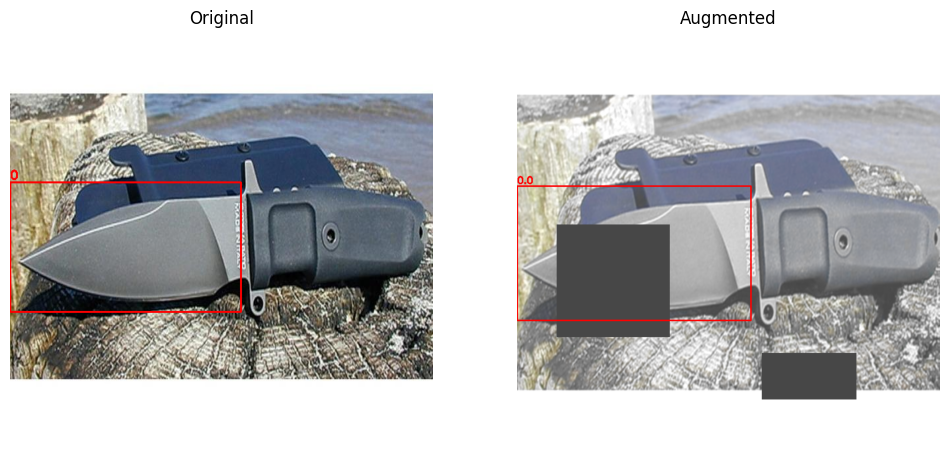

In [16]:
import cv2
import os
import random
import matplotlib.pyplot as plt

# Paths
img_dir = "/kaggle/working/dataset_balanced/train/images"
label_dir = "/kaggle/working/dataset_balanced/train/labels"

# Get image files
valid_ext = [".jpg", ".jpeg", ".png"]
all_images = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in valid_ext]

if not all_images:
    raise FileNotFoundError(f"No images found in {img_dir}")

# Pick random image
img_name = random.choice(all_images)
img_path = os.path.join(img_dir, img_name)

# Corresponding YOLO label file
label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

# Load image
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Could not read {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# Load YOLO bboxes
bboxes = []
class_labels = []
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            bboxes.append([x, y, bw, bh])  # normalized YOLO format
            class_labels.append(int(cls))
else:
    print("⚠️ No label file found, using dummy bbox.")
    bboxes = [[0.5, 0.5, 0.3, 0.3]]
    class_labels = [0]

# Helper: convert YOLO -> pixel coords
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, bw, bh = bbox
    x_min = int((x_c - bw/2) * img_w)
    y_min = int((y_c - bh/2) * img_h)
    x_max = int((x_c + bw/2) * img_w)
    y_max = int((y_c + bh/2) * img_h)
    return x_min, y_min, x_max, y_max

# Helper: draw bboxes
def draw_bboxes(img, bboxes, labels):
    img_copy = img.copy()
    for bbox, cls in zip(bboxes, labels):
        x_min, y_min, x_max, y_max = yolo_to_xyxy(bbox, img.shape[1], img.shape[0])
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img_copy, str(cls), (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return img_copy

# Original with boxes
img_with_boxes = draw_bboxes(image, bboxes, class_labels)

# Augmented
augmented = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_img = augmented["image"]
aug_bboxes = augmented["bboxes"]
aug_labels = augmented["class_labels"]
aug_with_boxes = draw_bboxes(aug_img, aug_bboxes, aug_labels)

# Show
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_with_boxes)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(aug_with_boxes)
plt.title("Augmented")
plt.axis("off")

plt.show()


In [17]:

base = "/kaggle/working/dataset_balanced"

splits = ["train", "valid", "test"]
classes = {0: "Knife", 1: "Gun"}

def count_classes(label_dir):
    counts = {0: 0, 1: 0}
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), "r") as f:
                lines = f.readlines()
                for line in lines:
                    cls_id = int(line.split()[0])  # first number = class id
                    counts[cls_id] += 1
    return counts

for split in splits:
    img_dir = os.path.join(base, split, "images")
    lbl_dir = os.path.join(base, split, "labels")

    num_images = len([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
    counts = count_classes(lbl_dir)

    print(f"\n📂 {split.upper()}:")
    print(f"   Total images: {num_images}")
    print(f"   Knife (class 0): {counts[0]}")
    print(f"   Gun   (class 1): {counts[1]}")


📂 TRAIN:
   Total images: 7000
   Knife (class 0): 3881
   Gun   (class 1): 4137

📂 VALID:
   Total images: 1500
   Knife (class 0): 846
   Gun   (class 1): 912

📂 TEST:
   Total images: 1500
   Knife (class 0): 842
   Gun   (class 1): 910


In [ ]:
ls /kaggle/working/dataset_balanced

In [ ]:
from ultralytics import YOLO

# Load pretrained small model
model = YOLO("yolov8m.pt")

model.train(
    data="/kaggle/working/dataset_balanced/data.yaml",  
    epochs=200,                        # enough for convergence
    imgsz=960,                         # fixed size, avoids resize overhead
    batch=8,                          # fits on T4 (drop to 8 if OOM)
    optimizer="AdamW",                 # better generalization for small datasets
    lr0=0.0005,                         # lower LR for AdamW
    lrf=0.01,                          # cosine decay to ~0.00002
    warmup_epochs=3,                   # smooth start            
    augment=True,                     # YOLO built-ins augmentation + Albumentations
    mosaic=0.5,
    mixup=0.1,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # keep mild color jitter
    workers=2, # Kaggle has 2 CPUs → best setting
    patience = 40,
    save_period=5,                     # save checkpoints every 5 epochs
    seed=42,                           # reproducibility
    amp=True                           # mixed precision → saves ~40% VRAM
)

In [ ]:
from ultralytics import YOLO

# Load pretrained small model
model = YOLO("/kaggle/input/epoch60/pytorch/default/1/epoch60.pt")

model.train(
    data="/kaggle/working/dataset_balanced/data.yaml",  
    epochs=200,                        # enough for convergence
    imgsz=800,                         # fixed size, avoids resize overhead
    batch=8,                          # fits on T4 (drop to 8 if OOM)
    optimizer="AdamW",                 # better generalization for small datasets
    lr0=0.0005,                         # lower LR for AdamW
    lrf=0.01,                          # cosine decay to ~0.00002
    warmup_epochs=3,                   # smooth start            
    augment=True,                     # YOLO built-ins augmentation + Albumentations
    mosaic=0.5,
    mixup=0.1,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # keep mild color jitter
    workers=2, # Kaggle has 2 CPUs → best setting
    patience = 40,
    save_period=5,                     # save checkpoints every 5 epochs
    seed=42,                           # reproducibility
    amp=True,# mixed precision → saves ~40% VRAM
    resume = True
)

Ultralytics 8.3.192 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_balanced/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=/kaggle/input/epoch60/pytorch/default/1/epoch60.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience

In [ ]:
# model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")
# model.train(
#     data="/kaggle/working/dataset_balanced/data.yaml",
#     epochs=200,      # total target (it will continue up to 200)
#     resume=True
# )

In [ ]:
# from ultralytics import YOLO

# # Load pretrained small model
# model = YOLO("/kaggle/input/resumept/epoch170.pt")

# model.train(
#     data="/kaggle/working/dataset_balanced/data.yaml",  
#     epochs=200,                        # enough for convergence
#     imgsz=640,                         # fixed size, avoids resize overhead
#     batch=16,                          # fits on T4 (drop to 8 if OOM)
#     optimizer="AdamW",                 # better generalization for small datasets
#     lr0=0.001,                         # lower LR for AdamW
#     lrf=0.01,                         # cosine decay to ~0.00002
#     warmup_epochs=3,                   # smooth start            
#     augment=True,                     # YOLO built-ins augmentation + Albumentations
#     mosaic=0.5,
#     mixup=0.1,
#     hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, # keep mild color jitter
#     workers=2, # Kaggle has 2 CPUs → best setting
#     patience = 50,
#     save_period=5,                     # save checkpoints every 5 epochs
#     seed=42,                           # reproducibility
#     amp=True,# mixed precision → saves ~40% VRAM
#     resume=True
# )

In [ ]:

# !ls runs/detect/train/weights   # confirm best.pt / last.pt
# !zip -r runs_detect_train.zip runs/detect/train


In [ ]:
# pwd

In [ ]:
model = YOLO("runs/detect/train/weights/last.pt")

metrics = model.val(data="/kaggle/working/dataset_balanced/data.yaml", imgsz=960)
print("mAP50:", metrics.box.map50, "  mAP50-95:", metrics.box.map)
print("Per-class mAP50:", metrics.box.maps)  # list aligned to names

In [ ]:
model.predict(source="/kaggle/working/dataset_balanced/valid/images", conf=0.25, save=True, imgsz=960)

In [ ]:
# model.predict(source="/kaggle/working/dataset_balanced/test/images/*.jpg", conf=0.35, imgsz=640, save=True)

In [ ]:
# from IPython.display import display, Image
# import cv2
# from ultralytics import YOLO

# model = YOLO("/kaggle/input/lastpt/last (9).pt")
# cap = cv2.VideoCapture("/kaggle/input/testvd/IMG_2078.MOV")

# ret, frame = cap.read()
# if ret:
#     results = model(frame)
#     annotated_frame = results[0].plot()
    
#     # Convert BGR → RGB
#     annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
#     _, encoded_img = cv2.imencode('.jpg', annotated_frame)
    
#     display(Image(data=encoded_img.tobytes()))
# cap.release()


In [ ]:
from ultralytics import YOLO
import cv2

model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")
video_path = "/kaggle/input/testvd/weapon_test1.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define VideoWriter
out = cv2.VideoWriter('tracked_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    annotated_frame = results[0].plot()
    
    # Write frame to output video
    out.write(annotated_frame)

cap.release()
out.release()
print("Video saved as tracked_video.mp4")


In [ ]:
# from ultralytics import YOLO
# import cv2
# model = YOLO("/kaggle/input/lastpt/last (9).pt")
# video_path = "/kaggle/input/testvd1/gun_testing1.MOV"
# cap = cv2.VideoCapture(video_path)

# # Get video properties
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = int(cap.get(cv2.CAP_PROP_FPS))

# # Define VideoWriter
# out = cv2.VideoWriter('tracked_video1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     results = model(frame)
#     annotated_frame = results[0].plot()
    
#     # Write frame to output video
#     out.write(annotated_frame)

# cap.release()
# out.release()
# print("Video saved as tracked_video1.mp4")